<a href="https://colab.research.google.com/github/Nuwanthapasindu/paddy-disease-prediction-ai-model/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!rm -rf "/content/paddy-disease-classification"

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip "/content/drive/MyDrive/ML_Learning/paddy-disease-prediction-ai-model/archive.zip"

Streaming output truncated to the last 5000 lines.
  inflating: paddy-disease-classification/train_images/hispa/104947.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104955.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104959.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104960.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104967.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104969.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104973.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104976.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104979.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104981.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104985.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104986.jpg  
  inflating: paddy-disease-classification/train_images/hispa/

In [6]:
data_set_path = "/content/paddy-disease-classification"
data_set_train_path = os.path.join(data_set_path, "train_images")
print(data_set_train_path)
data_set_test_path = os.path.join(data_set_path, "test_images")

/content/paddy-disease-classification/train_images


In [7]:
IMAGE_SIZE = 120
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
TRAIN_DATA_SIZE = 0.8
TEST_DATA_SIZE = 1 - TRAIN_DATA_SIZE
VALIDATION_DATA_SIZE = 0.1

In [8]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_set_train_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 19131 files belonging to 10 classes.


# Data Visualization

In [9]:
class_names = train_dataset.class_names
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [10]:
def calculate_class_counts(dataset,folder_path):
  class_names = dataset.class_names
  class_counts = {}
  for class_name in class_names:
    class_dir = os.path.join(folder_path, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))
  return class_counts


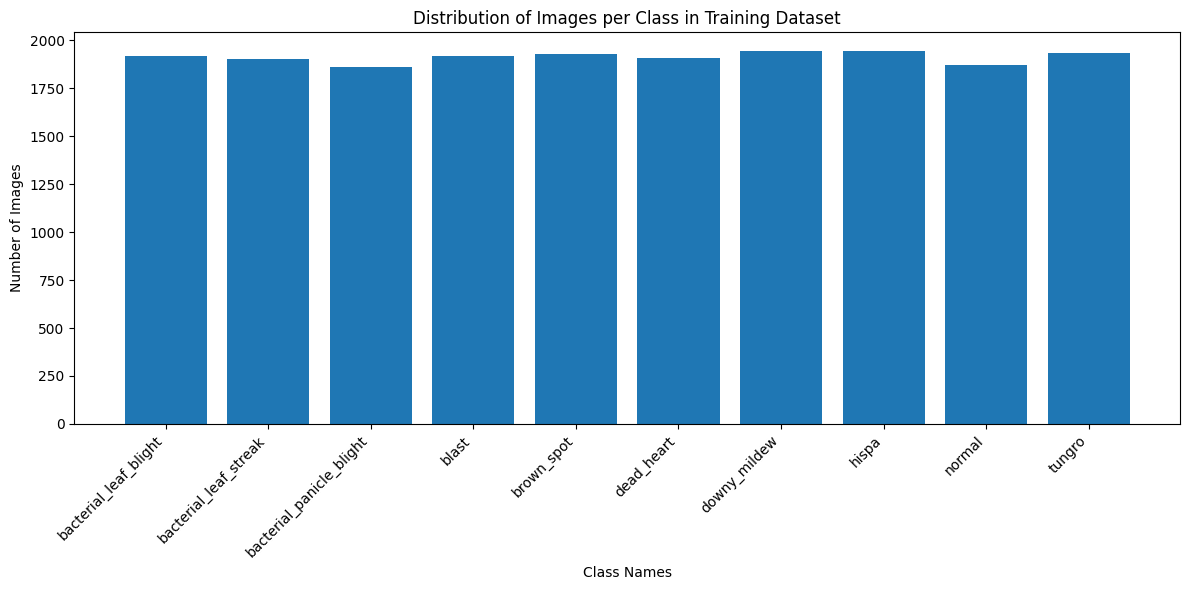

In [11]:
train_dataset_class_counts = calculate_class_counts(train_dataset,data_set_train_path)
plt.figure(figsize=(12, 6))
plt.bar(train_dataset_class_counts.keys(), train_dataset_class_counts.values())
plt.xticks(rotation=45, ha='right')
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Class in Training Dataset")
plt.tight_layout()
plt.show()

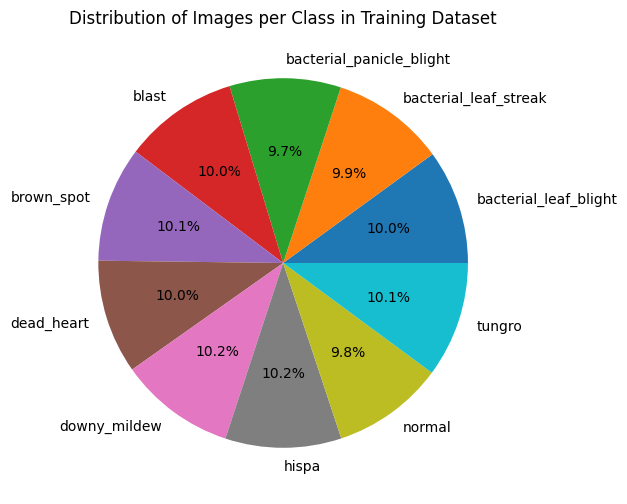

In [12]:
plt.figure(figsize=(12, 6))
plt.pie(train_dataset_class_counts.values(), labels=train_dataset_class_counts.keys(), autopct='%1.1f%%')
plt.title("Distribution of Images per Class in Training Dataset")
plt.show()

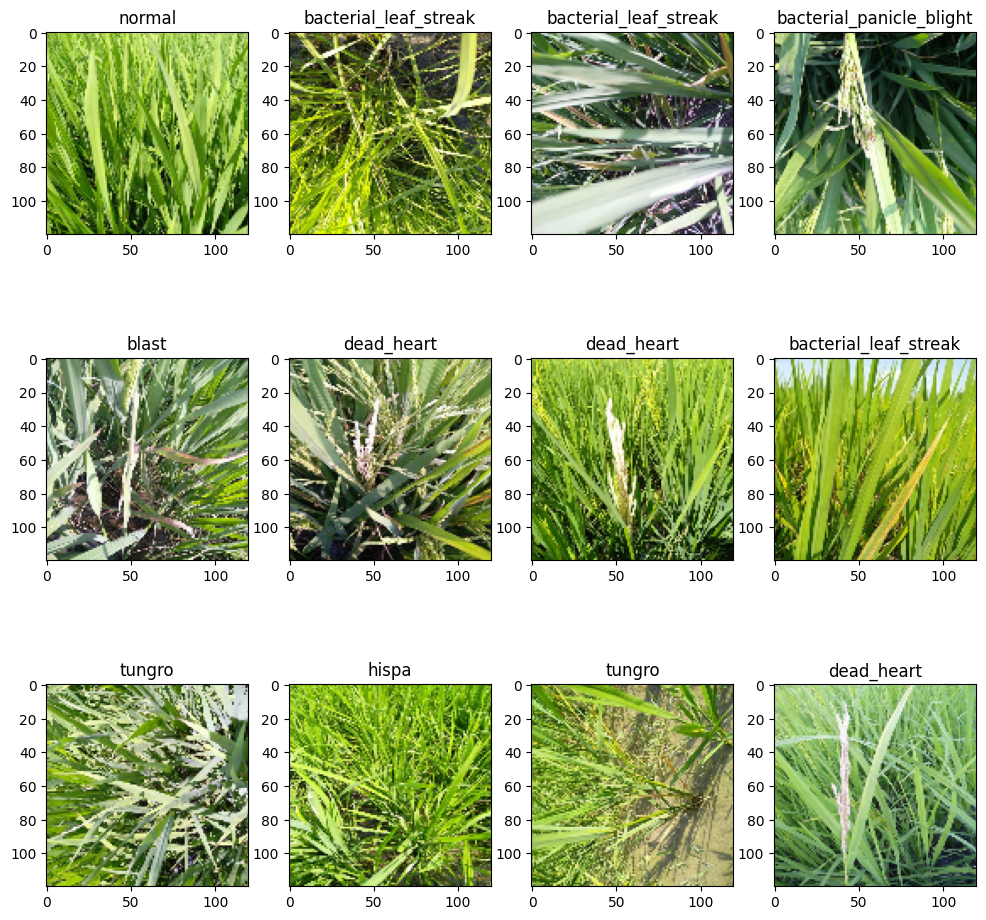

In [13]:
plt.figure(figsize=(12, 12))
for image_batch, label_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

## visiualize pre splitted test data

In [14]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_set_test_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 10407 files belonging to 10 classes.


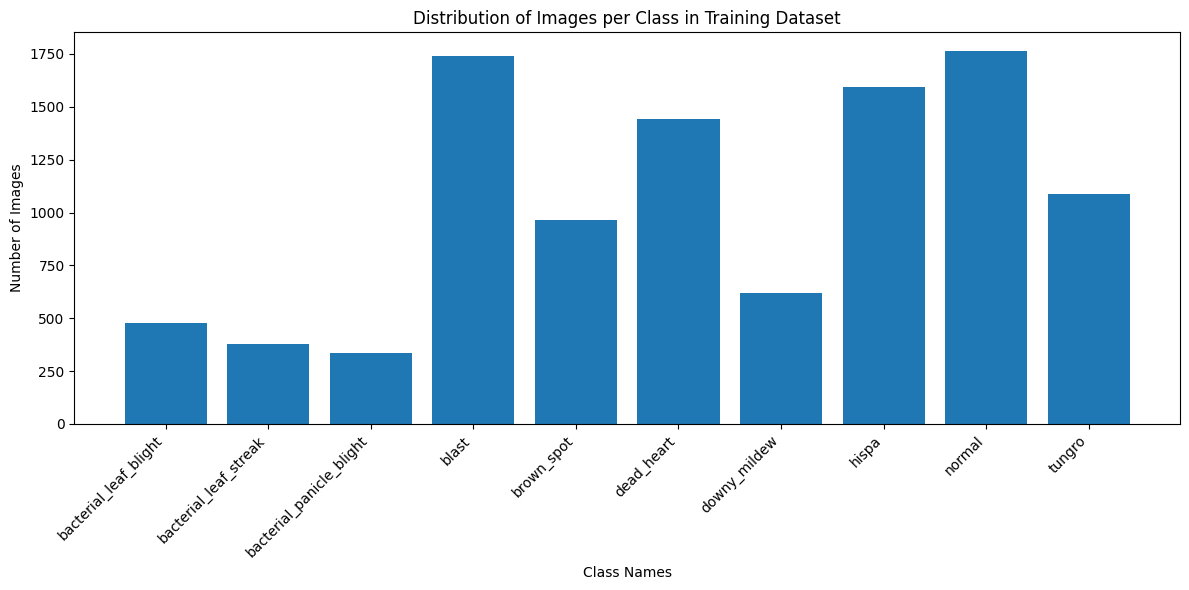

In [15]:
test_data_class_count = calculate_class_counts(test_data,data_set_test_path)
plt.figure(figsize=(12, 6))
plt.bar(test_data_class_count.keys(), test_data_class_count.values())
plt.xticks(rotation=45, ha='right')
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Class in Training Dataset")
plt.tight_layout()
plt.show()

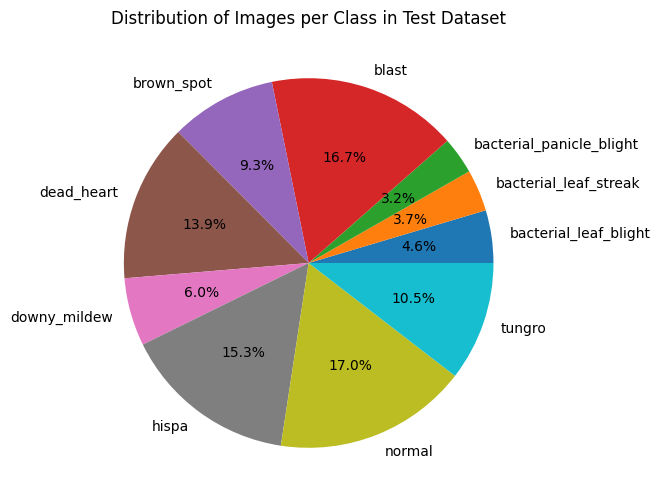

In [16]:
plt.figure(figsize=(12, 6))
plt.pie(test_data_class_count.values(), labels=test_data_class_count.keys(), autopct='%1.1f%%')
plt.title(f"Distribution of Images per Class in Test Dataset")
plt.show()

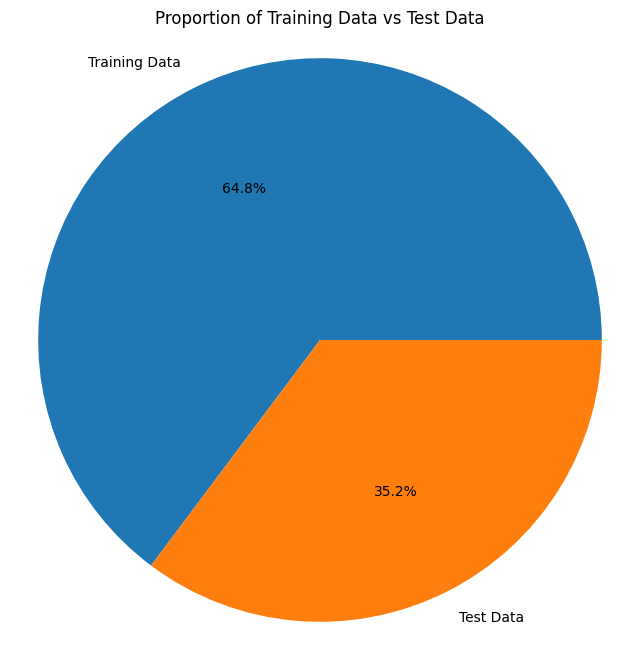

In [17]:
total_train_images = sum(train_dataset_class_counts.values())
total_test_images = sum(test_data_class_count.values())

labels = ['Training Data', 'Test Data']
sizes = [total_train_images, total_test_images]
colors = ['#1f77b4', '#ff7f0e']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=0)
plt.title("Proportion of Training Data vs Test Data")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# check pre defined test data are same or not

In [18]:
def extract_file_names_from_dataset(data_test_classes,data_set_path):
  train_data_names = []
  for class_name in data_test_classes:
      train_data_names.extend(os.listdir(os.path.join(data_set_path,class_name)))
  return set(train_data_names)

is_smae =  extract_file_names_from_dataset(train_dataset.class_names,data_set_train_path).intersection(extract_file_names_from_dataset(test_data.class_names,data_set_test_path))
if is_smae:
  print("test data and train data are same")
else:
  print("test data and train data are not same")

test data and train data are same


# Remove the pre-split test data folder and make the test data from the train data

In [19]:
!rm -rf "/content/paddy-disease-classification/test_images"

In [20]:
len(train_dataset)

598

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(train_dataset)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    validation_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,validation_ds,test_ds

In [22]:
train_ds,validation_ds,test_ds = get_dataset_partitions_tf(train_dataset)

In [23]:
len(train_ds),len(validation_ds),len(test_ds)

(478, 59, 61)

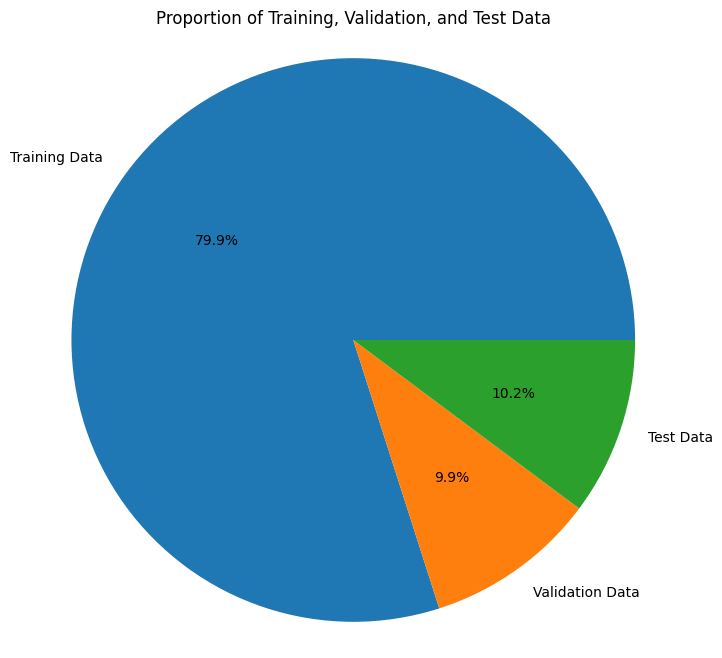

In [24]:
labels = ['Training Data', 'Validation Data', 'Test Data']
sizes = [len(train_ds), len(validation_ds), len(test_ds)]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=0)
plt.title("Proportion of Training, Validation, and Test Data")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Datasets optimization

In [25]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Image preprocessing

In [26]:
resize_and_scale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [50]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(factor=0.2),
])

# Model Build

In [52]:
input_shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_scale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu' ),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(len(class_names), activation='softmax')

])

In [53]:
model.build(input_shape=input_shape)

In [54]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 120, 120, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (32, 120, 120, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (32, 118, 118, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (32, 59, 59, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (32, 57, 57, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (32, 28, 28, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (32, 26, 26, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (32, 13, 13, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (32, 11, 11, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (32, 5, 5, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (32, 3, 3, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (32, 1, 1, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (32, 512)              │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 512)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (32, 10)               │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,586 (658.54 KB)

 Trainable params: 168,586 (658.54 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Model Training

In [ ]:
history = model.fit(train_ds,batch_size=BATCH_SIZE,validation_data=validation_ds,verbose=1,epochs=EPOCHS)

Epoch 1/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 97s 106ms/step - accuracy: 0.1316 - loss: 2.2619 - val_accuracy: 0.2754 - val_loss: 2.0366
Epoch 2/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 87s 100ms/step - accuracy: 0.2628 - loss: 2.0254 - val_accuracy: 0.2749 - val_loss: 1.9842
Epoch 3/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 143s 99ms/step - accuracy: 0.3250 - loss: 1.8682 - val_accuracy: 0.3957 - val_loss: 1.6861
Epoch 4/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 143s 100ms/step - accuracy: 0.3997 - loss: 1.6885 - val_accuracy: 0.4439 - val_loss: 1.5871
Epoch 5/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 88s 103ms/step - accuracy: 0.4527 - loss: 1.5775 - val_accuracy: 0.4756 - val_loss: 1.5181
Epoch 6/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 89s 102ms/step - accuracy: 0.4759 - loss: 1.4827 - val_accuracy: 0.5196 - val_loss: 1.3542
Epoch 7/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 89s 102ms/step - accuracy: 0.5286 - loss: 1.3604 - val_accuracy: 0.5514 - val_loss: 1.2675
Epoch 8/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 141s 100ms/step - accuracy: 0.5417 - loss:

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

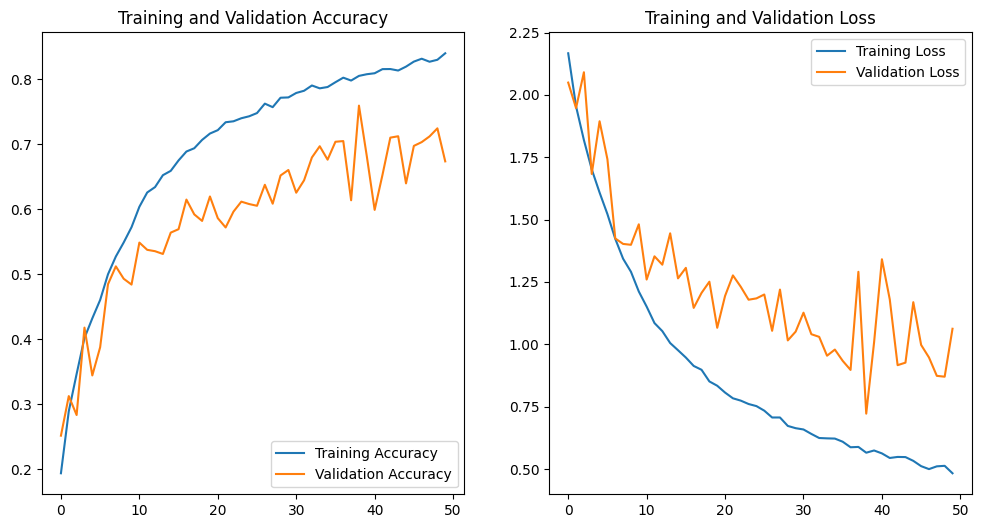

In [35]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: tungro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
predicted label: blast


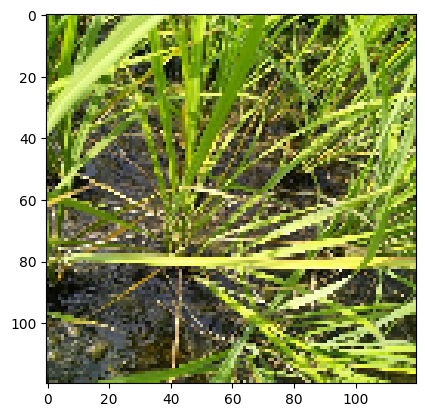

In [36]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [37]:
def predict(model,image_array):
  img_array = tf.expand_dims(image_array, 0)
  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


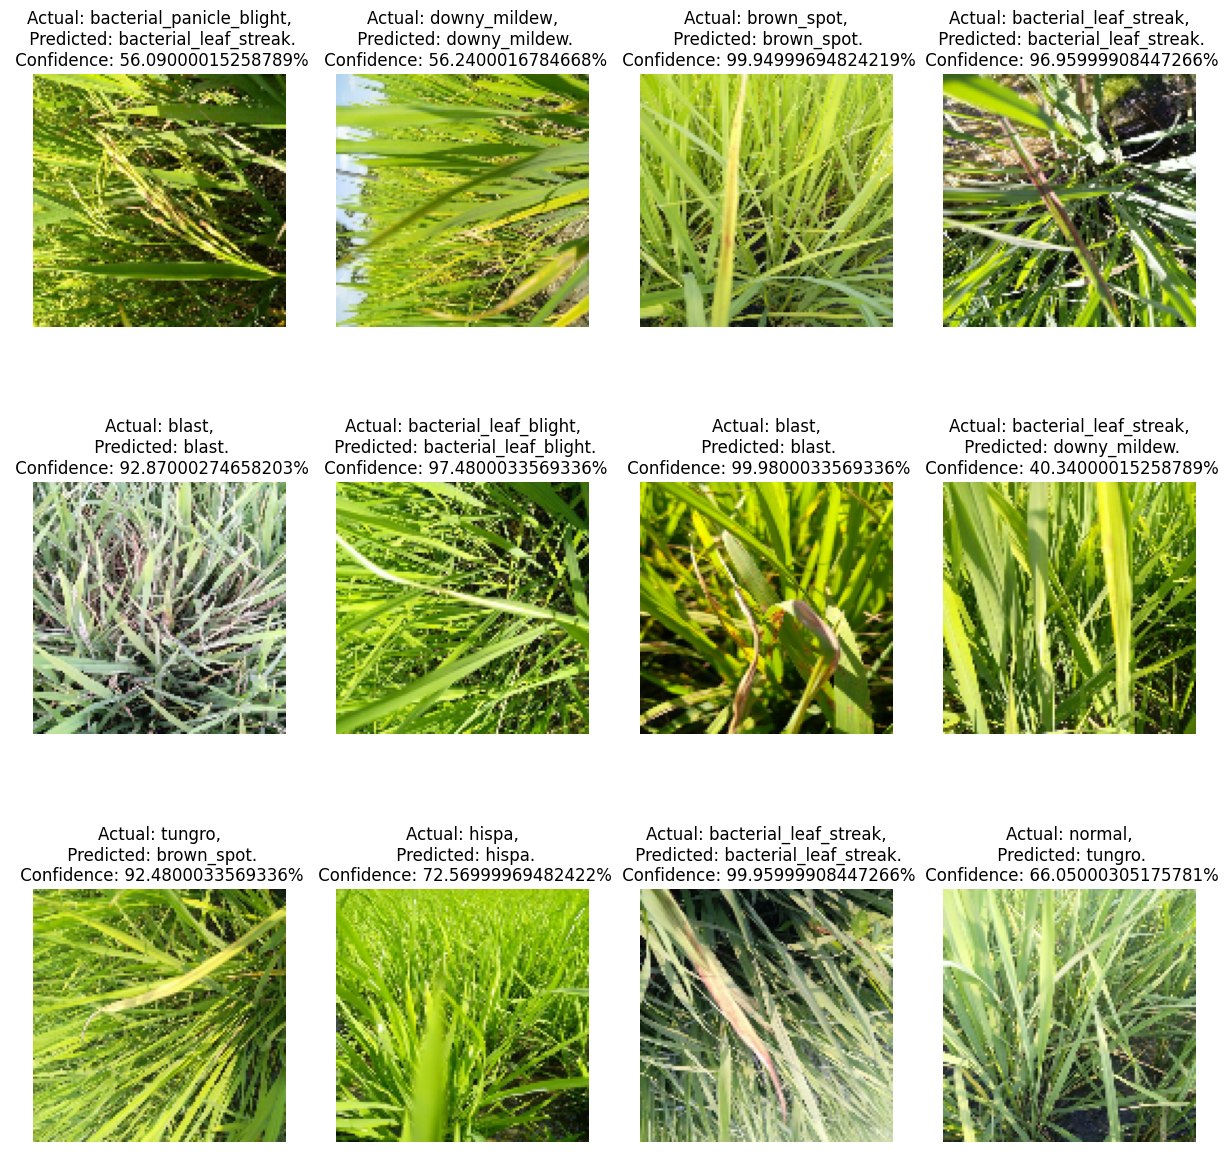

In [38]:
plt.figure(figsize=(15, 15))
for images,labels in test_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_class, confidence = predict(model,images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
    plt.axis("off")

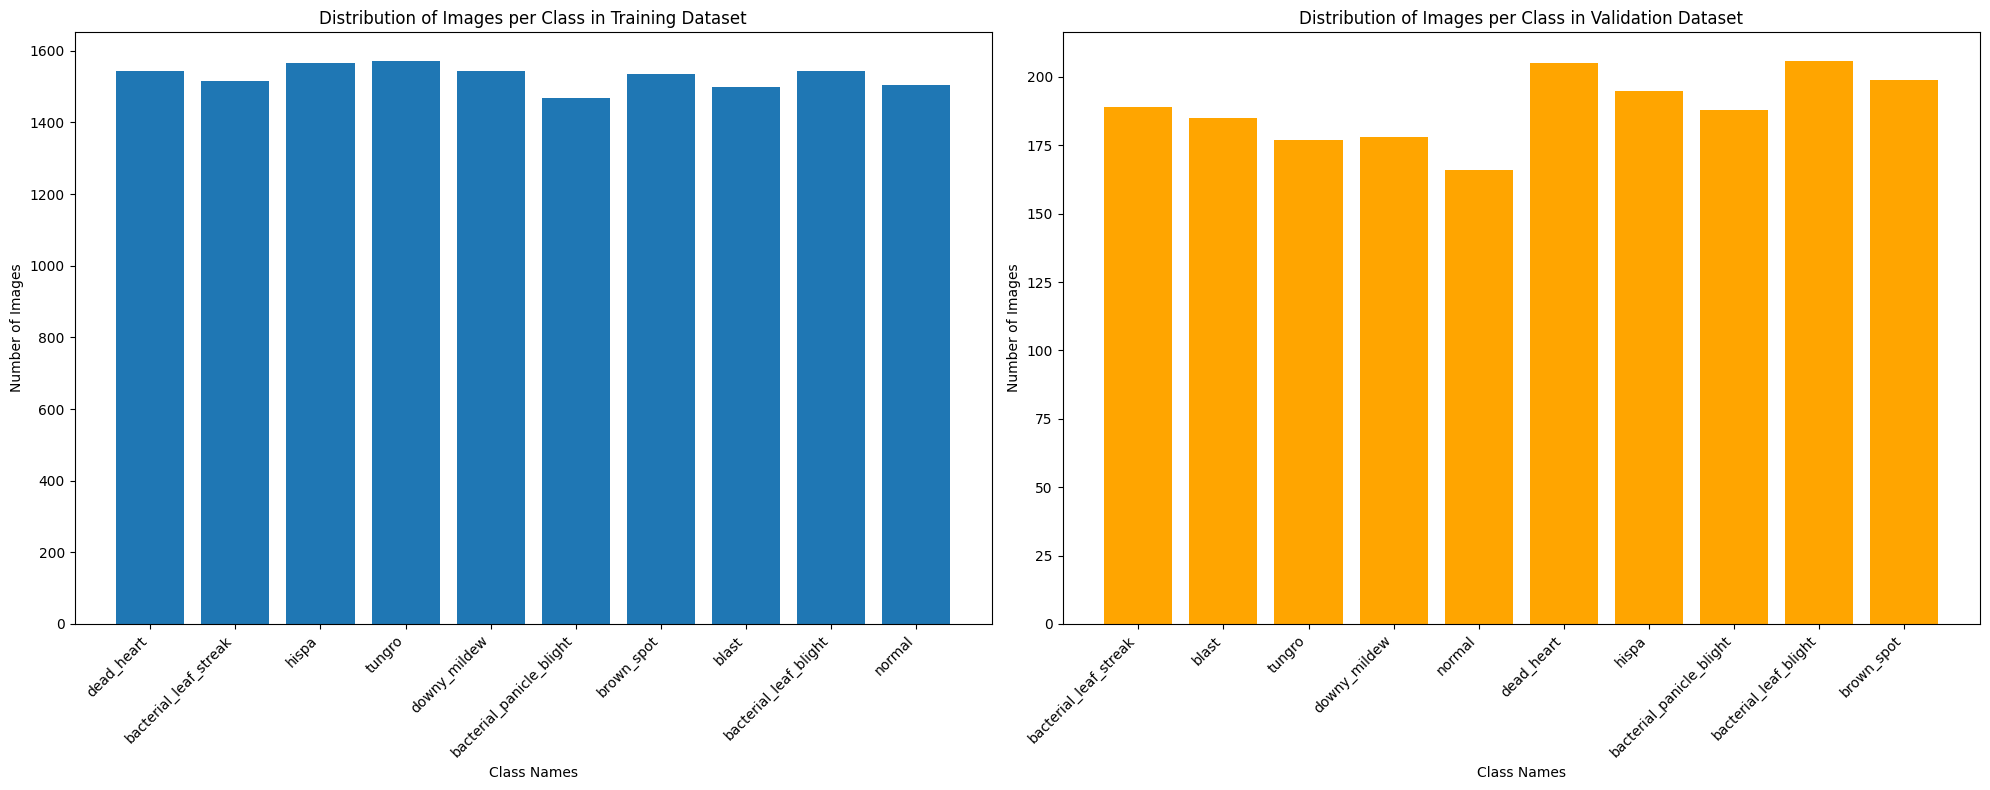

In [42]:
def calculate_class_counts(dataset):
    class_counts = {}
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
    return class_counts

# Calculate class counts for training and validation datasets
train_class_counts = calculate_class_counts(train_ds)
validation_class_counts = calculate_class_counts(validation_ds)

# Create a figure with two subplots for side-by-side charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Bar chart for training data
ax1.bar(train_class_counts.keys(), train_class_counts.values())
ax1.set_title('Distribution of Images per Class in Training Dataset')
ax1.set_xlabel('Class Names')
ax1.set_ylabel('Number of Images')
ax1.set_xticks(range(len(train_class_counts.keys())))
ax1.set_xticklabels(train_class_counts.keys(), rotation=45, ha='right')


# Bar chart for validation data
ax2.bar(validation_class_counts.keys(), validation_class_counts.values(), color='orange')
ax2.set_title('Distribution of Images per Class in Validation Dataset')
ax2.set_xlabel('Class Names')
ax2.set_ylabel('Number of Images')
ax2.set_xticks(range(len(validation_class_counts.keys())))
ax2.set_xticklabels(validation_class_counts.keys(), rotation=45, ha='right')

fig.tight_layout()
plt.show()

# Model Eveluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print("\nClassification Report:")
print(classification_report(test_labels, predicted_labels, target_names=class_names))

In [ ]:
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()